# Final Project - Dhairya Kantawala

First after seeing the data and reading the problem statement carefully I understood the following:
* 5 years of store-item sales data
* asked to predict 3 months of sales for 50 different items at 10 different stores
* Should stores be modeled separately or Pool together?
* Does deep learning work better than ARIMA here?
* Can either beat xgboost?
---
I think the best way to go by this is try different methods and see which gives the best result.

## Let's first organize our data and also visulize it (EDA)

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('demand-forecasting-kernels-only/train.csv', parse_dates=['date'])

In [83]:
print(train.info())
print(train.describe())
print(train.head())
# Just quick check on the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
None
                                date          store           item  \
count                         913000  913000.000000  913000.000000   
mean   2015-07-02 11:59:59.999999744       5.500000      25.500000   
min              2013-01-01 00:00:00       1.000000       1.000000   
25%              2014-04-02 00:00:00       3.000000      13.000000   
50%              2015-07-02 12:00:00       5.500000      25.500000   
75%              2016-10-01 00:00:00       8.000000      38.000000   
max              2017-12-31 00:00:00      10.000000      50.000000 

In [84]:
print(train.isnull().sum())
# No missing value, I like this :)

date     0
store    0
item     0
sales    0
dtype: int64


In [85]:
# For beautiful plottings
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

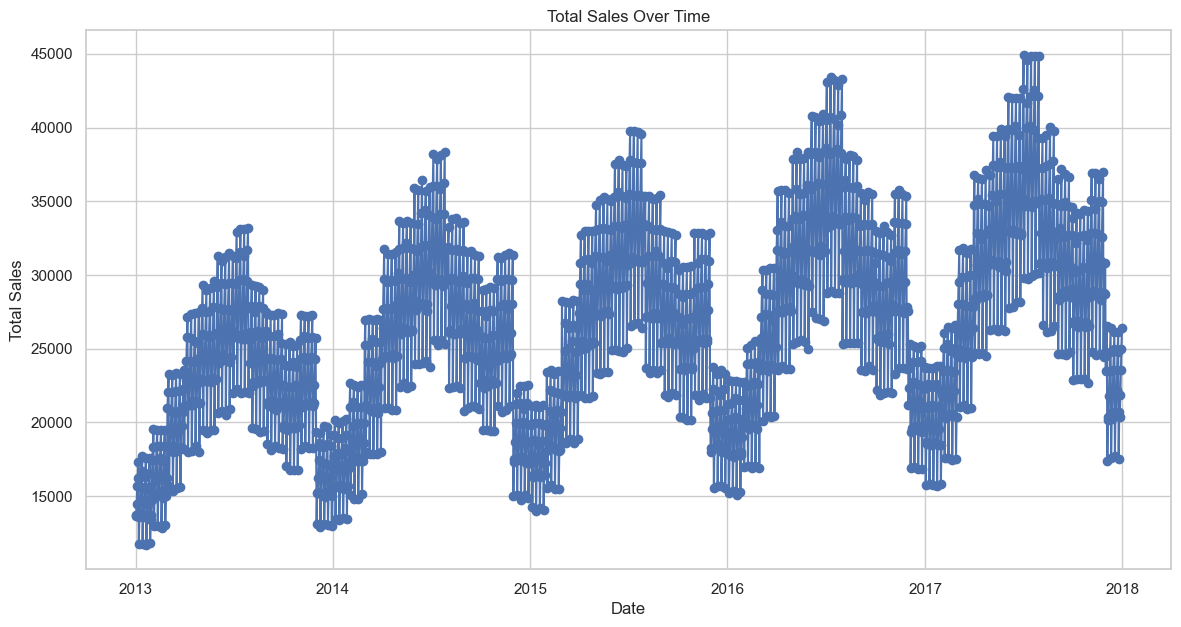

In [86]:
# Plot of total sales over time
total_sales = train.groupby('date').agg({'sales': 'sum'}).reset_index()
plt.figure(figsize=(14, 7))
plt.plot(total_sales['date'], total_sales['sales'], marker='o')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

# from the first graph itself we can see a nice seasonality pattern and also that is common for all 10 stores which is nice for us.

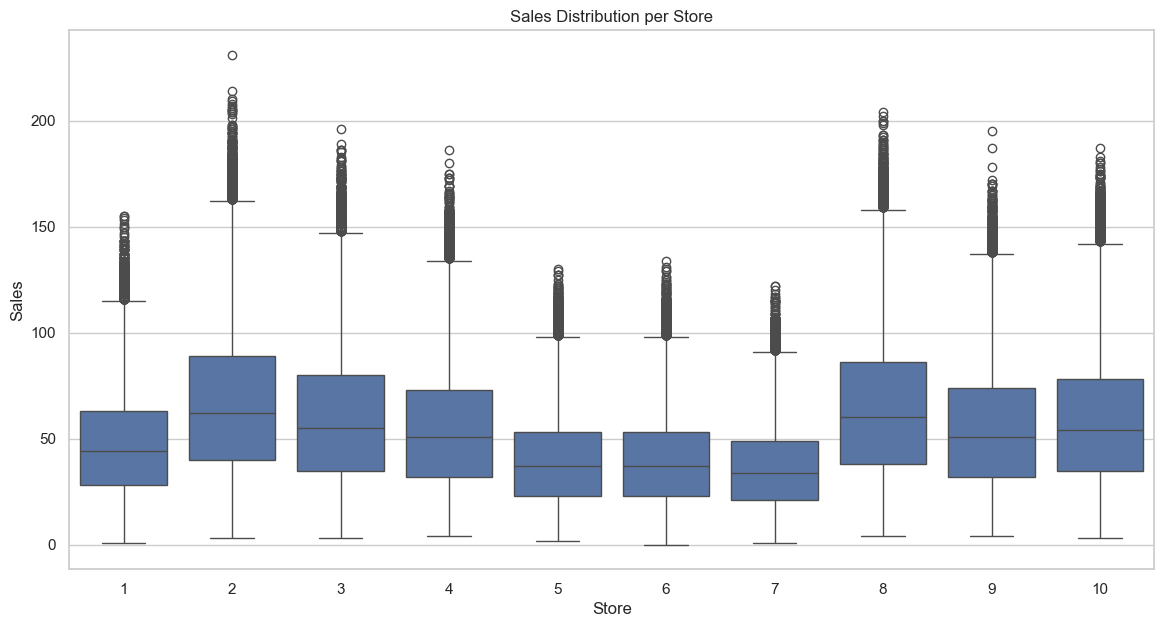

In [87]:
# Sales distribution per store
plt.figure(figsize=(14, 7))
sns.boxplot(x='store', y='sales', data=train)
plt.title('Sales Distribution per Store')
plt.xlabel('Store')
plt.ylabel('Sales')
plt.show()

# Did not gave me much insight.

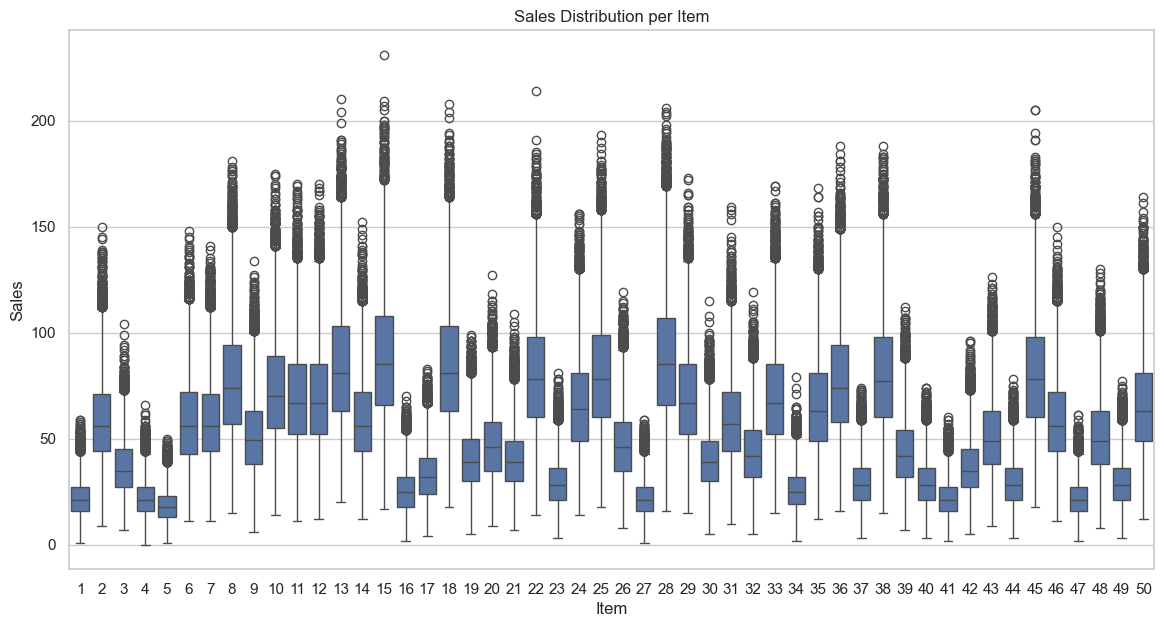

In [88]:
# Sales distribution per item
plt.figure(figsize=(14, 7))
sns.boxplot(x='item', y='sales', data=train)
plt.title('Sales Distribution per Item')
plt.xlabel('Item')
plt.ylabel('Sales')
plt.show()

# Again not a big insight, will help in knowing some famous items

/var/folders/wl/q8prsl_x2_g_hl0vv6cf0xj00000gn/T/ipykernel_52433/1117135052.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='sales', data=average_sales_by_dow, palette='viridis')


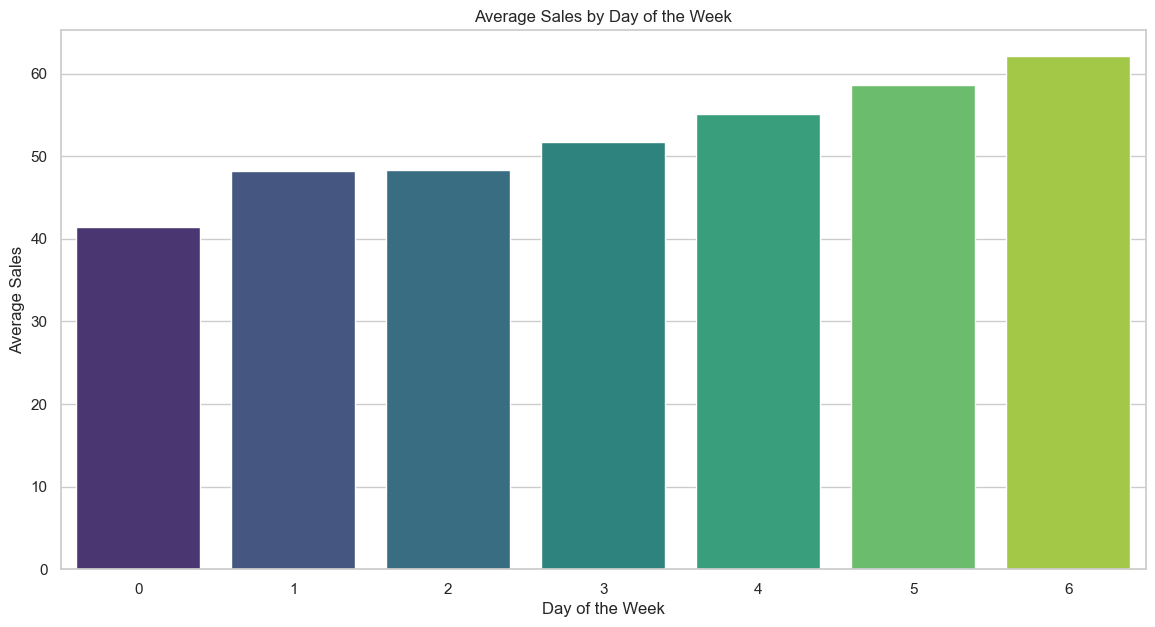

In [89]:
# Average sales by day of the week
train['day_of_week'] = train['date'].dt.dayofweek
average_sales_by_dow = train.groupby('day_of_week').agg({'sales': 'mean'}).reset_index()
plt.figure(figsize=(14, 7))
sns.barplot(x='day_of_week', y='sales', data=average_sales_by_dow, palette='viridis')
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Sales')
plt.show()

# This is a nice insight, this just means as the week goes by the sales gradually increase with the most over the weekend.


/var/folders/wl/q8prsl_x2_g_hl0vv6cf0xj00000gn/T/ipykernel_52433/1791902963.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='sales', data=average_sales_by_month, palette='viridis')


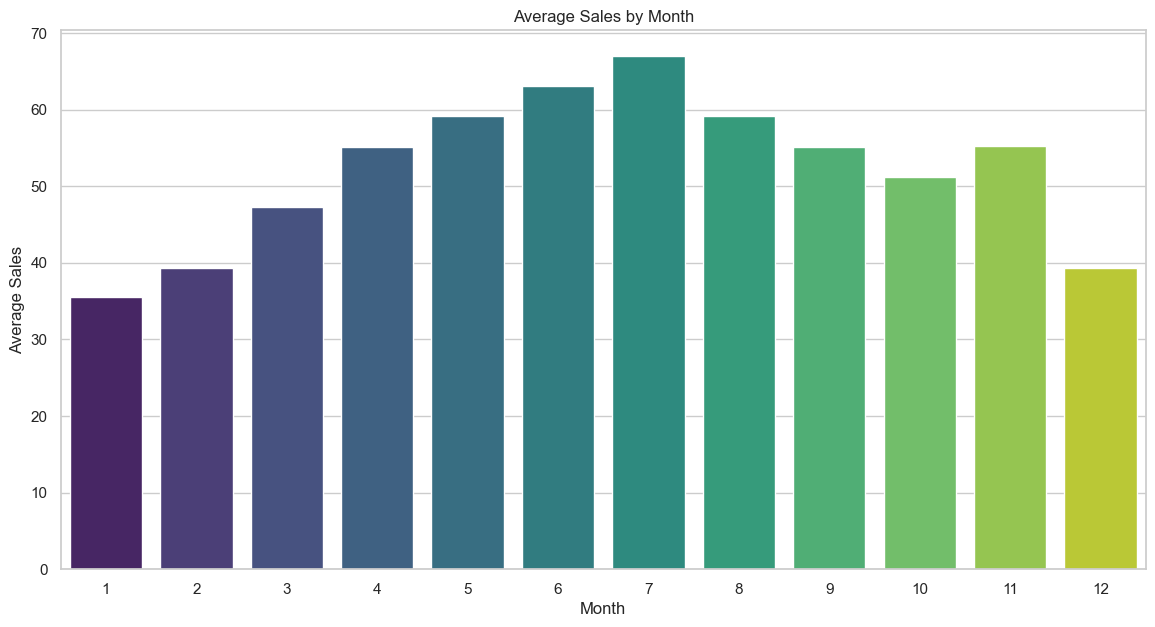

In [90]:
# Average sales by month
train['month'] = train['date'].dt.month
average_sales_by_month = train.groupby('month').agg({'sales': 'mean'}).reset_index()
plt.figure(figsize=(14, 7))
sns.barplot(x='month', y='sales', data=average_sales_by_month, palette='viridis')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.show()

# This is also very insigtful, this tells me that there is a nice pattern of sales which increases and then drops again, exclude month 11.

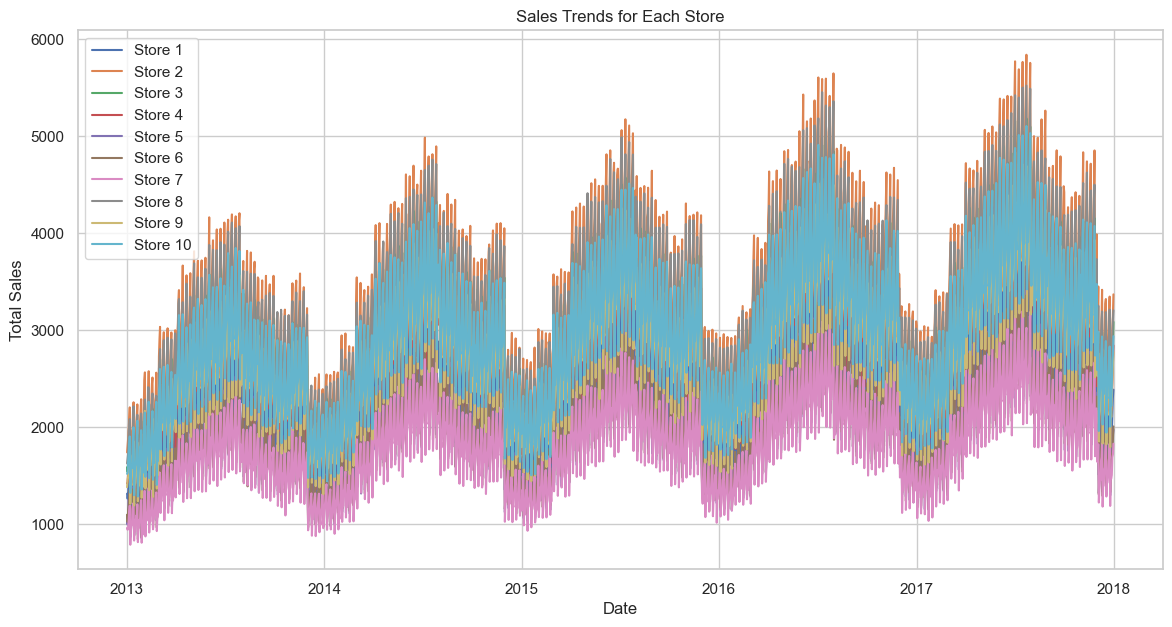

In [91]:
# Sales trends for each store
plt.figure(figsize=(14, 7))
for store_id in train['store'].unique():
    store_sales = train[train['store'] == store_id].groupby('date').agg({'sales': 'sum'}).reset_index()
    plt.plot(store_sales['date'], store_sales['sales'], label=f'Store {store_id}')
plt.title('Sales Trends for Each Store')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

# This is very similar to the first graph and shows a very nice seasonality data. We can also see that the month vise sales are also seasonal in every store.

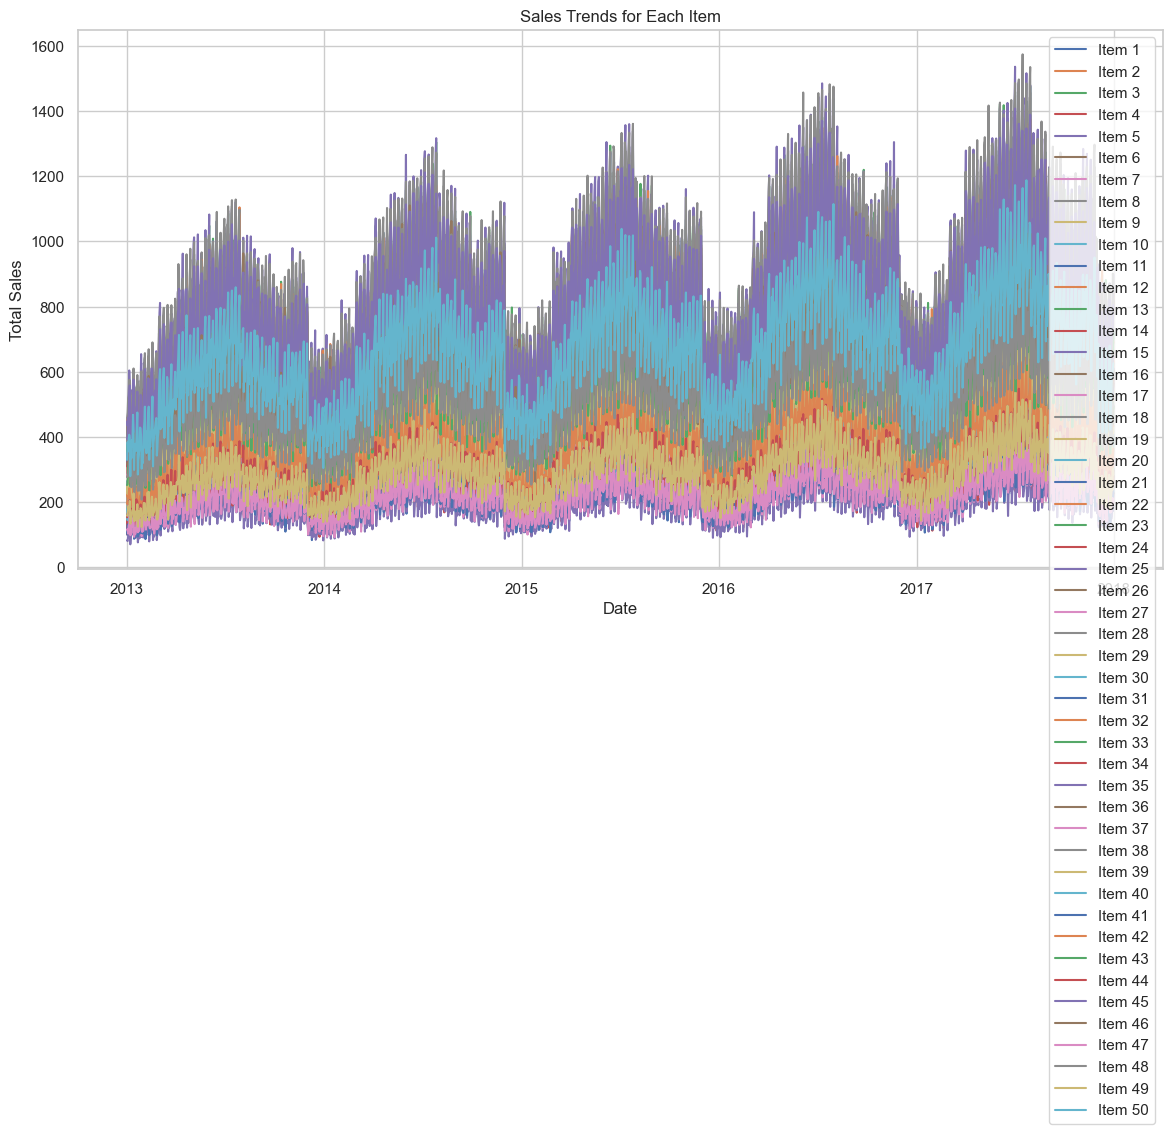

In [92]:
# Sales trends for each item
plt.figure(figsize=(14, 7))
for item_id in train['item'].unique():
    item_sales = train[train['item'] == item_id].groupby('date').agg({'sales': 'sum'}).reset_index()
    plt.plot(item_sales['date'], item_sales['sales'], label=f'Item {item_id}')
plt.title('Sales Trends for Each Item')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

# here also there is a nice seasonality, with this we can see that the most common items and least common has a very similar pattern.


## Now after EDA, let's try seasonal decomposition

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Aggregating data to daily total sales
total_sales_daily = train.groupby('date').agg({'sales': 'sum'}).reset_index()

# Assuming daily data with yearly seasonality (period=365)
result = seasonal_decompose(total_sales_daily['sales'], model='additive', period=365)


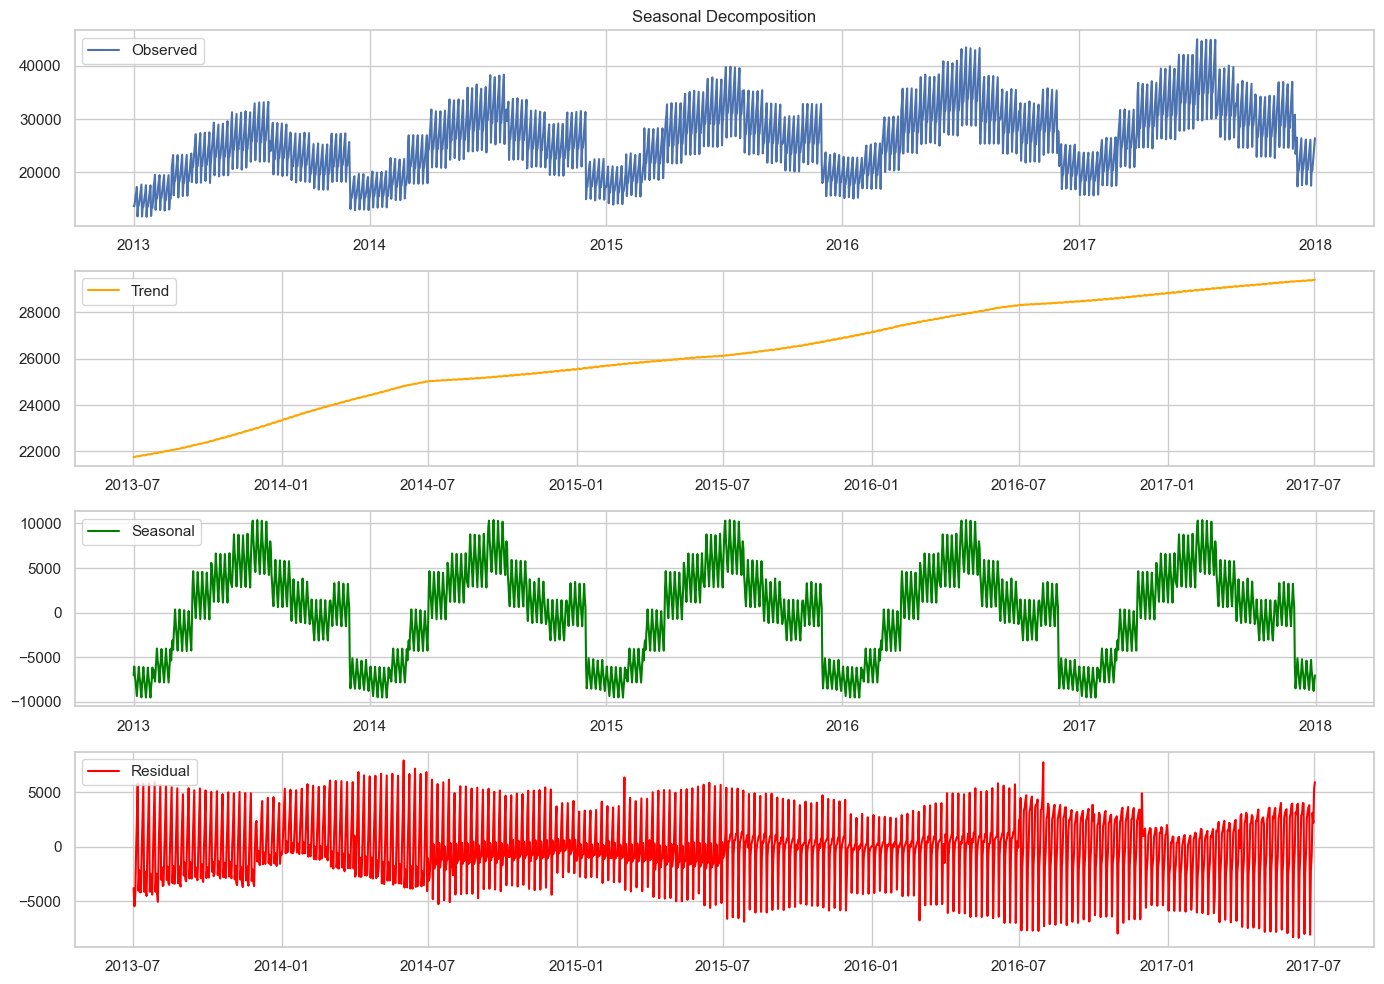

In [94]:
# Plot of original series
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(total_sales_daily['date'], result.observed, label='Observed')
plt.legend(loc='upper left')
plt.title('Seasonal Decomposition')

# Plot of trend component
plt.subplot(412)
plt.plot(total_sales_daily['date'], result.trend, label='Trend', color='orange')
plt.legend(loc='upper left')

# Plot of seasonal component
plt.subplot(413)
plt.plot(total_sales_daily['date'], result.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')

# Plot of residual component
plt.subplot(414)
plt.plot(total_sales_daily['date'], result.resid, label='Residual', color='red')
plt.legend(loc='upper left')


plt.tight_layout()
plt.show()

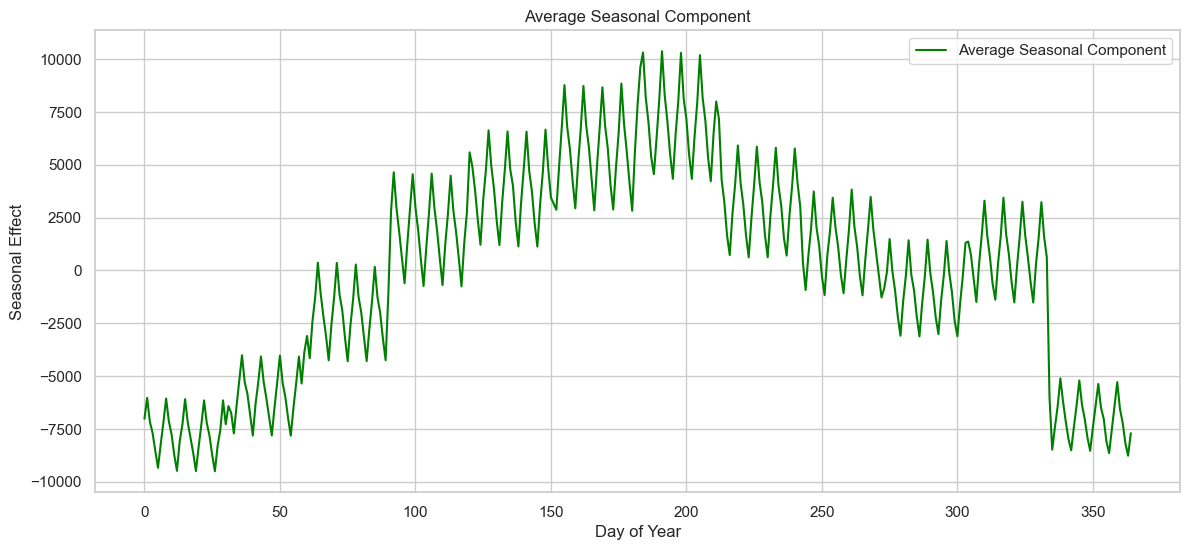

In [95]:
# Additional insights
# Average seasonal component over the years, doing this as there is clearly a pattern ever year
seasonal_mean = result.seasonal.groupby(result.seasonal.index % 365).mean()
plt.figure(figsize=(14, 6))
plt.plot(seasonal_mean, label='Average Seasonal Component', color='green')
plt.title('Average Seasonal Component')
plt.xlabel('Day of Year')
plt.ylabel('Seasonal Effect')
plt.legend()
plt.show()

## Let's start with (store, item) SAIRMA modeling

Train Data:
        date  store  item  sales  day_of_week  month
0 2013-01-01      1     1     13            1      1
1 2013-01-02      1     1     11            2      1
2 2013-01-03      1     1     14            3      1
3 2013-01-04      1     1     13            4      1
4 2013-01-05      1     1     10            5      1

Data Types After Date Conversion:
date           datetime64[ns]
store                   int64
item                    int64
sales                   int64
day_of_week             int32
month                   int32
dtype: object

Pivoted Train Data:
store         1                                                         ...  \
item          1     2     3     4     5     6     7     8     9     10  ...   
date                                                                    ...   
2013-01-01  13.0  33.0  15.0  10.0  11.0  31.0  25.0  33.0  18.0  37.0  ...   
2013-01-02  11.0  43.0  30.0  11.0   6.0  36.0  23.0  37.0  23.0  34.0  ...   
2013-01-03  14.0  23.0  1

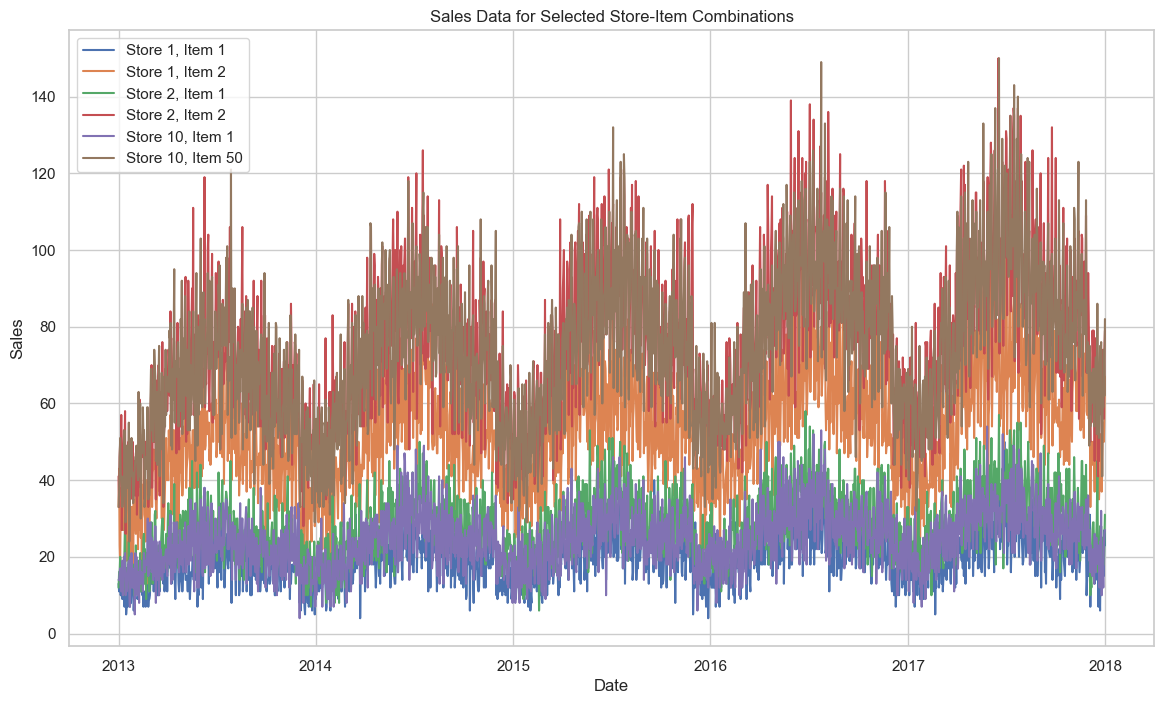

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

#lets see first:
print("Train Data:")
print(train.head())

# then we convert to datetime
train['date'] = pd.to_datetime(train['date'])

# just checking once again
print("\nData Types After Date Conversion:")
print(train.dtypes)

# Pivot the data
train_pivot = train.pivot_table(index='date', columns=['store', 'item'], values='sales')

# Print the first few rows of the pivoted data
print("\nPivoted Train Data:")
print(train_pivot.head())

# Visualize the data for a few store-item combinations
store_item_combinations = [(1, 1), (1, 2), (2, 1), (2, 2), (10, 1), (10, 50)]

plt.figure(figsize=(14, 8))
for store, item in store_item_combinations:
    plt.plot(train_pivot.index, train_pivot[(store, item)], label=f'Store {store}, Item {item}')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Data for Selected Store-Item Combinations')
plt.legend()
plt.show()


# okay so much better visulisation, and we can see that the seasonality is continued, so far so good.

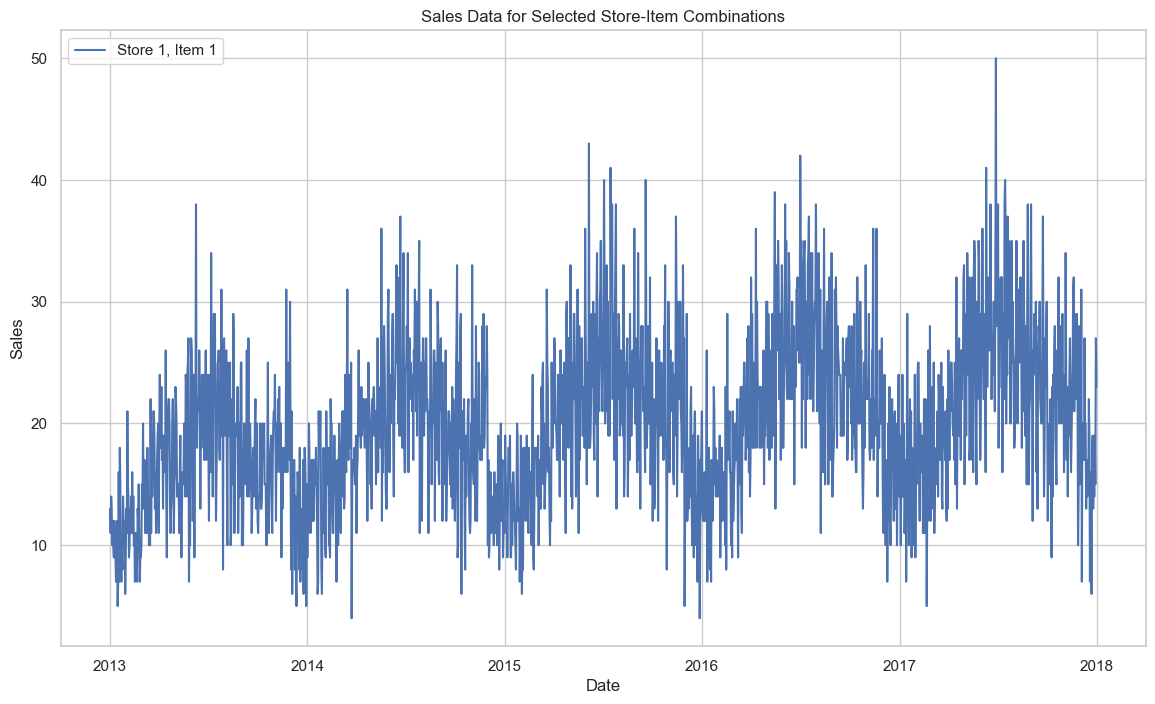


Dataset for Store 1, Item 1:
            sales
date             
2013-01-01   13.0
2013-01-02   11.0
2013-01-03   14.0
2013-01-04   13.0
2013-01-05   10.0


In [97]:
# Visualize the data for a store-item combinations
store_item_combinations = [(1, 1)]

plt.figure(figsize=(14, 8))
for store, item in store_item_combinations:
    plt.plot(train_pivot.index, train_pivot[(store, item)], label=f'Store {store}, Item {item}')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Data for Selected Store-Item Combinations')
plt.legend()
plt.show()


dataset_1_1 = pd.DataFrame({
    'sales': train_pivot[(1, 1)]
})

print("\nDataset for Store 1, Item 1:")
print(dataset_1_1.head())

In [98]:
df = dataset_1_1
#here I am trying to do SARMA on only one then will do for every.

In [99]:
import pandas as pd

# Assuming your data is in a DataFrame called `df`
df['date'] = pd.to_datetime(df.index)
df.set_index('date', inplace=True)


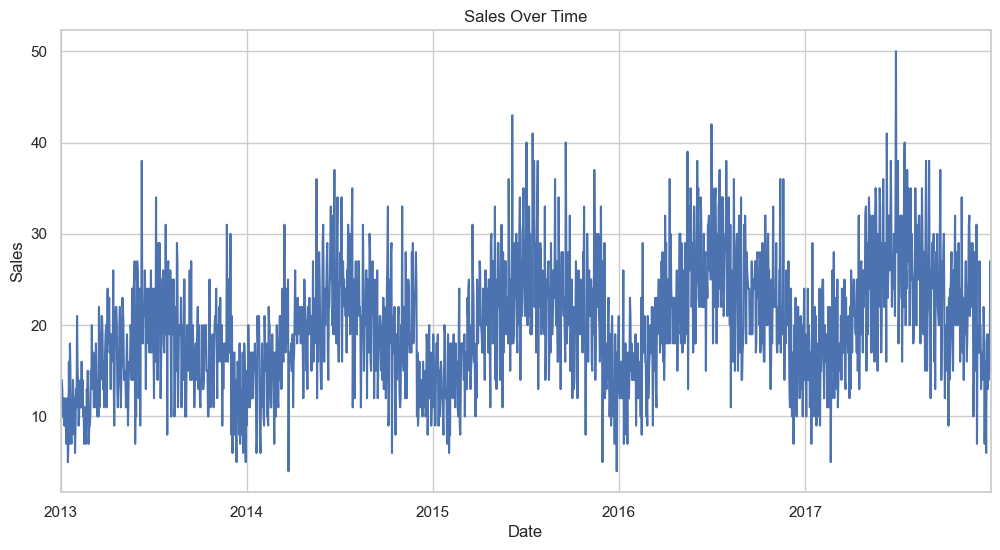

In [100]:
import matplotlib.pyplot as plt

df['sales'].plot(figsize=(12, 6))
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


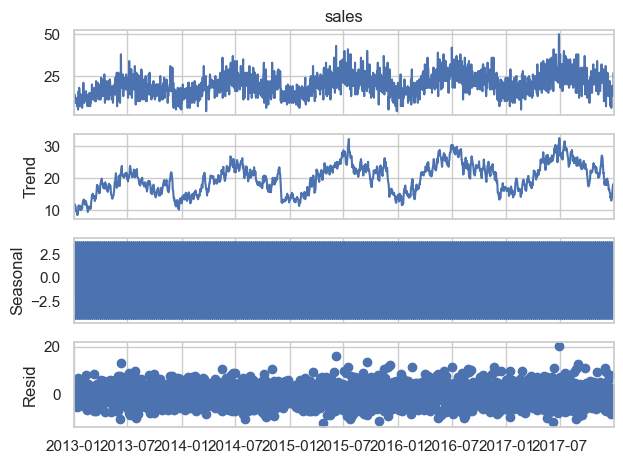

In [101]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['sales'], model='additive')
result.plot()
plt.show()



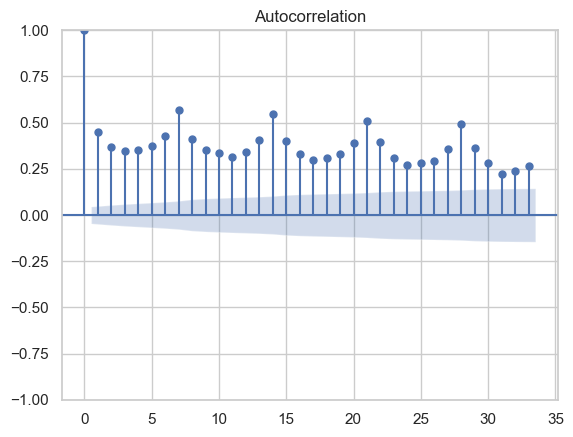

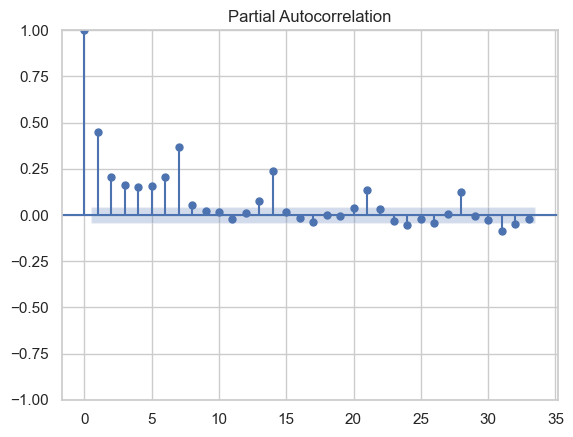

ADF Statistic: -3.1576705563328202
p-value: 0.02256938062657048


In [102]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
plot_acf(df['sales'])
plot_pacf(df['sales'])
plt.show()

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

In [103]:
#okay so if we want like accurate model with SAIRMA we have to have a lot of paitence, sadly I don't have it

## Let's get (1,1) using xgboost

In [104]:
df['date'] = pd.to_datetime(df.index)
df

,sales,date
date,,
2013-01-01,13.0,2013-01-01
2013-01-02,11.0,2013-01-02
2013-01-03,14.0,2013-01-03
2013-01-04,13.0,2013-01-04
2013-01-05,10.0,2013-01-05
...,...,...
2017-12-27,14.0,2017-12-27
2017-12-28,19.0,2017-12-28
2017-12-29,15.0,2017-12-29


In [105]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [106]:
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

train_df.head()

,sales,date
date,,
2013-01-01,13.0,2013-01-01
2013-01-02,11.0,2013-01-02
2013-01-03,14.0,2013-01-03
2013-01-04,13.0,2013-01-04
2013-01-05,10.0,2013-01-05


/var/folders/wl/q8prsl_x2_g_hl0vv6cf0xj00000gn/T/ipykernel_52433/3757001035.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'year'] = df['date'].dt.year
/var/folders/wl/q8prsl_x2_g_hl0vv6cf0xj00000gn/T/ipykernel_52433/3757001035.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'month'] = df['date'].dt.month
/var/folders/wl/q8prsl_x2_g_hl0vv6cf0xj00000gn/T/ipykernel_52433/3757001035.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

RMSE: 4.99


/opt/anaconda3/envs/clean/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


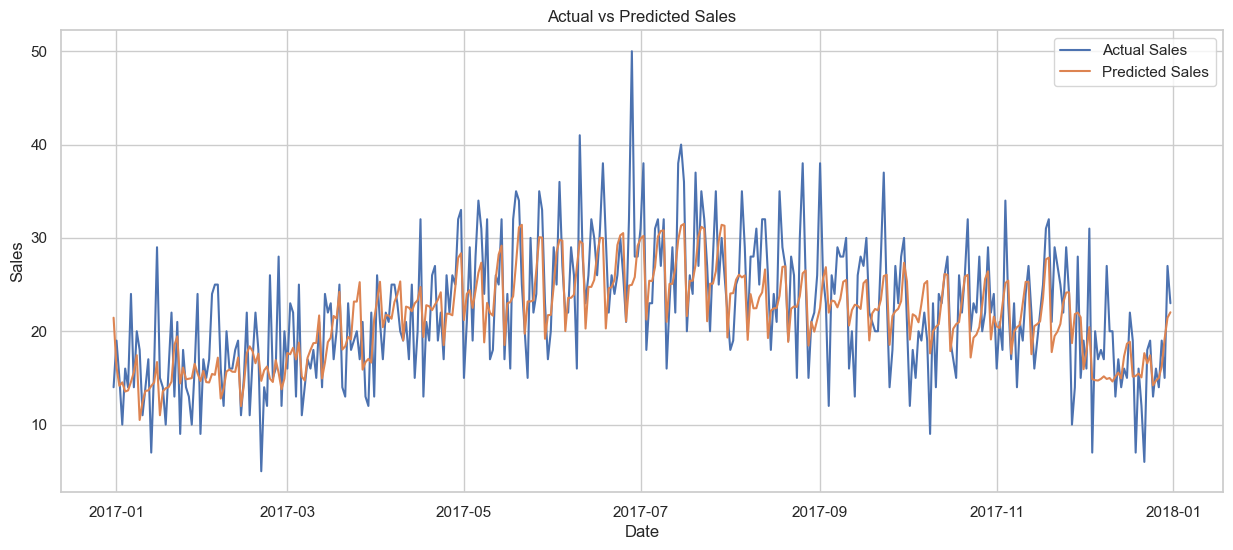

In [107]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt



# Feature engineering
def create_features(df):
    df.loc[:, 'year'] = df['date'].dt.year
    df.loc[:, 'month'] = df['date'].dt.month
    df.loc[:, 'day'] = df['date'].dt.day
    df.loc[:, 'day_of_week'] = df['date'].dt.dayofweek
    df.loc[:, 'day_of_year'] = df['date'].dt.dayofyear
    df.loc[:, 'week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    return df

train_df = create_features(train_df)
test_df = create_features(test_df)

# Separate features and target
X_train = train_df.drop(['date', 'sales'], axis=1)
y_train = train_df['sales']
X_test = test_df.drop(['date', 'sales'], axis=1)
y_test = test_df['sales']

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10000, learning_rate=0.01)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse:.2f}')

plt.figure(figsize=(15, 6))
plt.plot(test_df['date'], y_test, label='Actual Sales')
plt.plot(test_df['date'], y_pred, label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()

In [108]:
import numpy as np

def calculate_smape(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + epsilon)) * 100

smape = calculate_smape(y_test, y_pred)
print(f'SMAPE: {smape:.2f}%')

SMAPE: 9.47%


## Let's get (1,1) using LightGBM

In [109]:
df = df.drop(columns='date')

In [110]:
df

,sales
date,
2013-01-01,13.0
2013-01-02,11.0
2013-01-03,14.0
2013-01-04,13.0
2013-01-05,10.0
...,...
2017-12-27,14.0
2017-12-28,19.0
2017-12-29,15.0


In [111]:
import pandas as pd
from sklearn.model_selection import train_test_split


df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year

In [112]:
df

,sales,day,month,year
date,,,,
2013-01-01,13.0,1,1,2013
2013-01-02,11.0,2,1,2013
2013-01-03,14.0,3,1,2013
2013-01-04,13.0,4,1,2013
2013-01-05,10.0,5,1,2013
...,...,...,...,...
2017-12-27,14.0,27,12,2017
2017-12-28,19.0,28,12,2017
2017-12-29,15.0,29,12,2017


In [113]:
X = df[['day', 'month', 'year']]
y = df['sales']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [115]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt'
}

model = lgb.train(
    params,
    train_data, num_boost_round=10000,
    valid_sets=[test_data]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 3
[LightGBM] [Info] Start training from score 19.422603


Root Mean Squared Error: 7.159668530790061


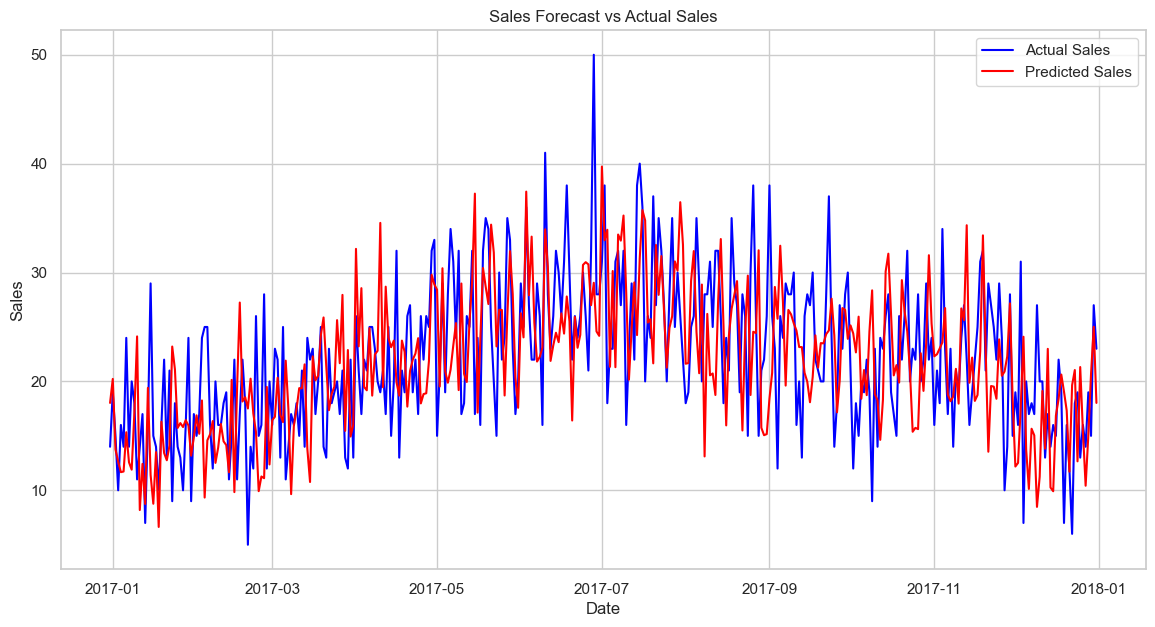

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Sales', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast vs Actual Sales')
plt.legend()
plt.show()


In [117]:
import numpy as np

def calculate_smape(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + epsilon)) * 100

smape = calculate_smape(y_test, y_pred)
print(f'SMAPE: {smape:.2f}%')

SMAPE: 13.61%


## Let's get (1,1) using prophet

## Let's get (1,1) using LSTM

I mean I can use it but they have asked to predict next 3 months, this will be very inacurate